In [1]:
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import Dataset
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Name:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model, to_categorical
tf.debugging.set_log_device_placement(False)
tf.config.experimental_run_functions_eagerly(False)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
tf.debugging.set_log_device_placement(False)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
# from torch.utils.data import DataLoader
from scipy.ndimage import zoom
from glob import glob
import re
from skimage import measure
import torchio as tio
import shutil
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

2025-04-02 12:47:05.221432: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 12:47:05.258285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 12:47:05.258311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 12:47:05.258335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 12:47:05.265590: I tensorflow/core/platform/cpu_feature_g

TensorFlow Version: 2.14.0
Num GPUs Available: 2
GPU Name: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


/home/student11/anaconda3/envs/mlmed-huyproman/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROCESSED_DIR = "/home/student11/ds/mlmed-huyproman/cropped_slices_processed_320"

for dataset in ["training", 'validation', 'testing']:
    dataset_path = os.path.join(PROCESSED_DIR, dataset)
    print(f"\n📁 Dataset: {dataset}\n{'-' * 40}")
    
    for patient_folder in os.listdir(dataset_path):
        patient_path = os.path.join(dataset_path, patient_folder)
        
        if not os.path.isdir(patient_path):
            continue

        for file in os.listdir(patient_path):
            if file.endswith(".nii.gz"):
                file_path = os.path.join(patient_path, file)
                
                try:
                    img = nib.load(file_path)
                    voxel_spacing = img.header.get_zooms()
                    shape = img.shape
                    print(f"- {file_path}")
                    print(f"  🧊 Spacing: {voxel_spacing}")
                    print(f"  📐 Shape: {shape}\n")
                except Exception as e:
                    print(f"❌ Error loading {file_path}: {e}")


📁 Dataset: training
----------------------------------------
- /home/student11/ds/mlmed-huyproman/cropped_slices_processed_320/training/patient025/patient025_ES_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 5)

- /home/student11/ds/mlmed-huyproman/cropped_slices_processed_320/training/patient025/patient025_ED_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 7)

- /home/student11/ds/mlmed-huyproman/cropped_slices_processed_320/training/patient025/patient025_ED_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 7)

- /home/student11/ds/mlmed-huyproman/cropped_slices_processed_320/training/patient025/patient025_ES_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 5)

- /home/student11/ds/mlmed-huyproman/cropped_slices_processed_320/training/patient029/patient029_ES_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 7)

- /home/student11/ds/mlmed-huyproman/cropped_slices_processed_320/tra

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Conv3DTranspose, concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

def conv_block_3d(x, filters):
    x = Conv3D(filters, (3, 3, 1), padding="same", kernel_initializer='he_normal')(x)  
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv3D(filters, (3, 3, 1), padding="same", kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    return x

def upsample_block_3d(x, conv_features, filters):
    x = Conv3DTranspose(filters, (2, 2, 1), strides=(2, 2, 1), padding="same")(x)  # Upsample only in x-y
    x = concatenate([x, conv_features])
    x = conv_block_3d(x, filters)
    return x

def unet_3d(input_shape=(224, 224, 10, 1), num_classes=4):
    inputs = Input(input_shape)

    c1 = conv_block_3d(inputs, 24)  
    p1 = MaxPooling3D((2, 2, 1))(c1)  # Pooling only in x-y

    c2 = conv_block_3d(p1, 48)
    p2 = MaxPooling3D((2, 2, 1))(c2)

    c3 = conv_block_3d(p2, 96)
    p3 = MaxPooling3D((2, 2, 1))(c3)

    c4 = conv_block_3d(p3, 192)
    p4 = MaxPooling3D((2, 2, 1))(c4)

    c5 = conv_block_3d(p4, 384)  
    
    u6 = upsample_block_3d(c5, c4, 192)
    u7 = upsample_block_3d(u6, c3, 96)
    u8 = upsample_block_3d(u7, c2, 48)
    u9 = upsample_block_3d(u8, c1, 24)

    
    ds1 = Conv3D(num_classes, (1, 1, 1), activation='softmax', name='ds1')(u7)  
    ds2 = Conv3D(num_classes, (1, 1, 1), activation='softmax', name='ds2')(u8)  

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax', name='main')(u9)  

    model = Model(inputs, [outputs, ds1, ds2], name="3D_UNet")
    return model

model = unet_3d()
model.summary()

2025-04-02 12:47:38.279568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6653 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:12:00.0, compute capability: 7.5
2025-04-02 12:47:38.280852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:86:00.0, compute capability: 7.5


Model: "3D_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 10, 1)]    0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 224, 224, 10, 24)     240       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 10, 24)     96        ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 10, 24)     0         ['batch_normalization[0]

In [3]:
def crop_or_pad_volume(volume, target_shape=(224, 224, 10)):
    z, x, y = volume.shape
    z_target, x_target, y_target = target_shape

    if z < z_target:
        pad_z = z_target - z
        pad_before = pad_z // 2
        pad_after = pad_z - pad_before
        volume = np.pad(volume, ((pad_before, pad_after), (0, 0), (0, 0)), mode='constant')
    elif z > z_target:
        start_z = (z - z_target) // 2
        volume = volume[start_z:start_z + z_target, :, :]

    if x < x_target or y < y_target:
        volume = np.pad(volume, ((0, 0), (0, x_target - x), (0, y_target - y)), mode='constant')
    elif x > x_target or y > y_target:
        start_x = (x - x_target) // 2
        start_y = (y - y_target) // 2
        volume = volume[:, start_x:start_x + x_target, start_y:start_y + y_target]

    return volume

def load_patient_volume(patient_folder, num_classes=4):
    images, masks = [], []

    for phase in ["ED", "ES"]:
        image_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_processed.nii.gz")
        mask_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_gt_processed.nii.gz")

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"⚠️ Missing file: {image_path} or {mask_path}")
            continue  

        image_nii = nib.load(image_path)
        mask_nii = nib.load(mask_path)

        image_array = image_nii.get_fdata()
        mask_array = mask_nii.get_fdata()

        image_array = (image_array - np.mean(image_array)) / (np.std(image_array) + 1e-10)

        image_array = crop_or_pad_volume(image_array, target_shape=(224, 224, 10))
        mask_array = crop_or_pad_volume(mask_array, target_shape=(224, 224, 10))

        image_array = np.expand_dims(image_array, axis=-1)
        mask_array = to_categorical(mask_array, num_classes=num_classes).astype("float32")

        images.append(image_array)
        masks.append(mask_array)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

def load_dataset(root_dir, dataset_type):
    images, masks = [], []
    dataset_path = os.path.join(root_dir, dataset_type)

    for patient_folder in sorted(os.listdir(dataset_path)):
        patient_path = os.path.join(dataset_path, patient_folder)

        if os.path.isdir(patient_path):
            patient_id = patient_folder[-3:]
            patient_images, patient_masks = load_patient_volume(patient_path, num_classes=4)
            print(f"✅ Loaded {len(patient_images)} volumes and {len(patient_masks)} masks from {patient_folder}")
            images.extend(patient_images)
            masks.extend(patient_masks)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

X_train, Y_train = load_dataset("/home/student11/ds/mlmed-huyproman/cropped_slices_processed_320", "training")
X_val, Y_val = load_dataset('/home/student11/ds/mlmed-huyproman/cropped_slices_processed_320', 'validation')

print(f"✅ Training Data: {X_train.shape}, {Y_train.shape}")
print(f"✅ Validation Data: {X_val.shape}, {Y_val.shape}")

✅ Loaded 2 volumes and 2 masks from patient001
✅ Loaded 2 volumes and 2 masks from patient002
✅ Loaded 2 volumes and 2 masks from patient003
✅ Loaded 2 volumes and 2 masks from patient004
✅ Loaded 2 volumes and 2 masks from patient005
✅ Loaded 2 volumes and 2 masks from patient006
✅ Loaded 2 volumes and 2 masks from patient007
✅ Loaded 2 volumes and 2 masks from patient008
✅ Loaded 2 volumes and 2 masks from patient009
✅ Loaded 2 volumes and 2 masks from patient010
✅ Loaded 2 volumes and 2 masks from patient011
✅ Loaded 2 volumes and 2 masks from patient012
✅ Loaded 2 volumes and 2 masks from patient013
✅ Loaded 2 volumes and 2 masks from patient014
✅ Loaded 2 volumes and 2 masks from patient015
✅ Loaded 2 volumes and 2 masks from patient016
✅ Loaded 2 volumes and 2 masks from patient021
✅ Loaded 2 volumes and 2 masks from patient022
✅ Loaded 2 volumes and 2 masks from patient023
✅ Loaded 2 volumes and 2 masks from patient024
✅ Loaded 2 volumes and 2 masks from patient025
✅ Loaded 2 vo

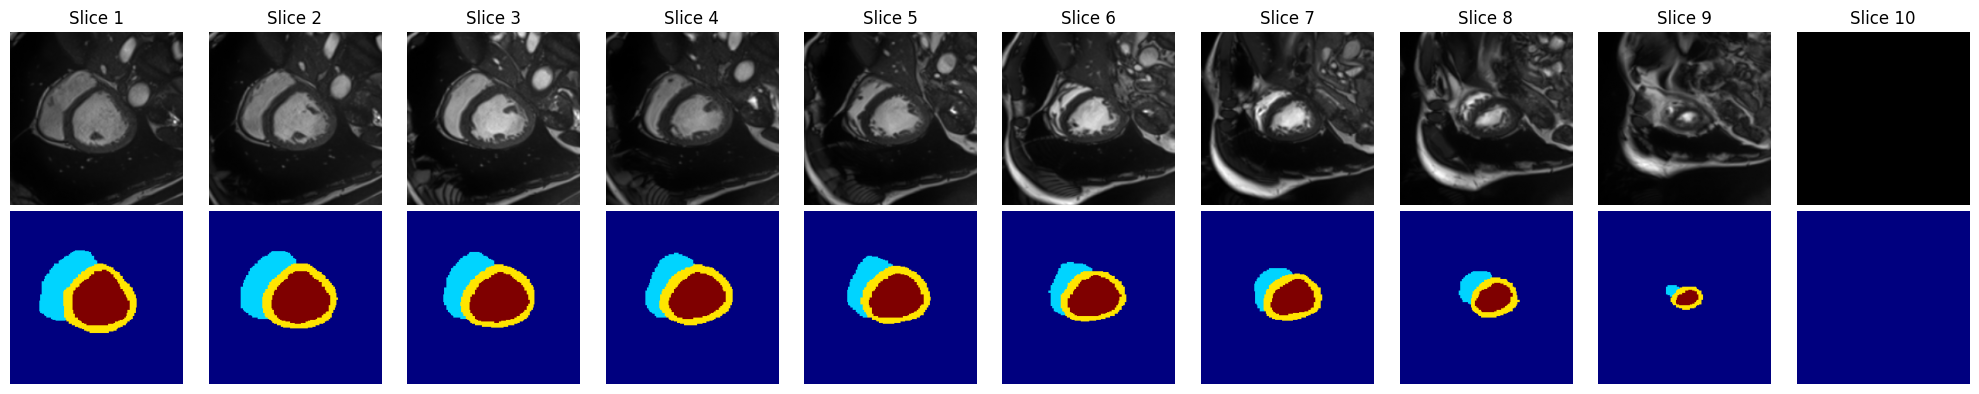

In [5]:
def visualize_3d(x, y, index):
    volume = x[index, ..., 0]  
    mask = y[index, ..., :]  

    depth = volume.shape[-1]

    fig, axs = plt.subplots(2, depth, figsize=(2 * depth, 4))

    for i in range(depth):
        axs[0, i].imshow(volume[..., i], cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f'Slice {i+1}')

        seg_slice = np.argmax(mask[..., i, :], axis=-1)
        axs[1, i].imshow(seg_slice, cmap='jet', vmin=0, vmax=3)  
        axs[1, i].axis('off')

    axs[0, 0].set_ylabel("MRI", rotation=0, labelpad=30)
    axs[1, 0].set_ylabel("Mask", rotation=0, labelpad=30)

    plt.tight_layout()
    plt.show()

visualize_3d(X_train, Y_train, 8)

In [ ]:
def downsample_mask_tf(mask, target_size):
    target_x, target_y = target_size
    mask = tf.transpose(mask, [2, 0, 1, 3])  
    downsampled = tf.image.resize(mask, (target_x, target_y), method='nearest')
    downsampled = tf.transpose(downsampled, [1, 2, 0, 3])  
    
    return downsampled

def prepare_targets(image, main_mask):
    ds2_mask = downsample_mask_tf(main_mask, (112, 112))  
    ds1_mask = downsample_mask_tf(main_mask, (56, 56))
    return image, {'main': main_mask, 'ds1': ds1_mask, 'ds2': ds2_mask}

def random_gamma_3d(image):
    image = tf.clip_by_value(image, 1e-3, 1.0)
    gamma = tf.random.uniform([], 0.9, 1.1)
    return tf.pow(image, gamma)

def augment_3d(image, main_mask):
    if tf.random.uniform(()) > 0.9:
        image = tf.reverse(image, axis=[1])
        main_mask = tf.reverse(main_mask, axis=[1])
    
    if tf.random.uniform(()) > 0.9:
        image = tf.reverse(image, axis=[0])
        main_mask = tf.reverse(main_mask, axis=[0])
    
    if tf.random.uniform(()) > 0.6:
        image = random_gamma_3d(image)
    
    if tf.random.uniform(()) > 0.9:
        offset = tf.random.normal([1], mean=0.0, stddev=20.0, dtype=tf.float32)
        shift = tf.cast(offset, tf.int32)[0]
        image = tf.roll(image, shift=shift, axis=2)
        main_mask = tf.roll(main_mask, shift=shift, axis=2)
    return image, main_mask

def create_tf_dataset(images, masks, batch_size, augment_data):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    if augment_data:
        dataset = dataset.map(augment_3d, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(prepare_targets, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE) # If and only if you want to shuffle
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    train_dataset = create_tf_dataset(X_train, Y_train, batch_size=4, augment_data=True)
    valid_dataset = create_tf_dataset(X_val, Y_val, batch_size=4, augment_data=False)

for batch in train_dataset.take(1):
    images, targets = batch
    print("Batch image shape:", images.shape)
    print("Batch targets shapes:", {k: v.shape for k, v in targets.items()})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Batch image shape: (4, 224, 224, 10, 1)
Batch targets shapes: {'main': TensorShape([4, 224, 224, 10, 4]), 'ds1': TensorShape([4, 56, 56, 10, 4]), 'ds2': TensorShape([4, 112, 112, 10, 4])}


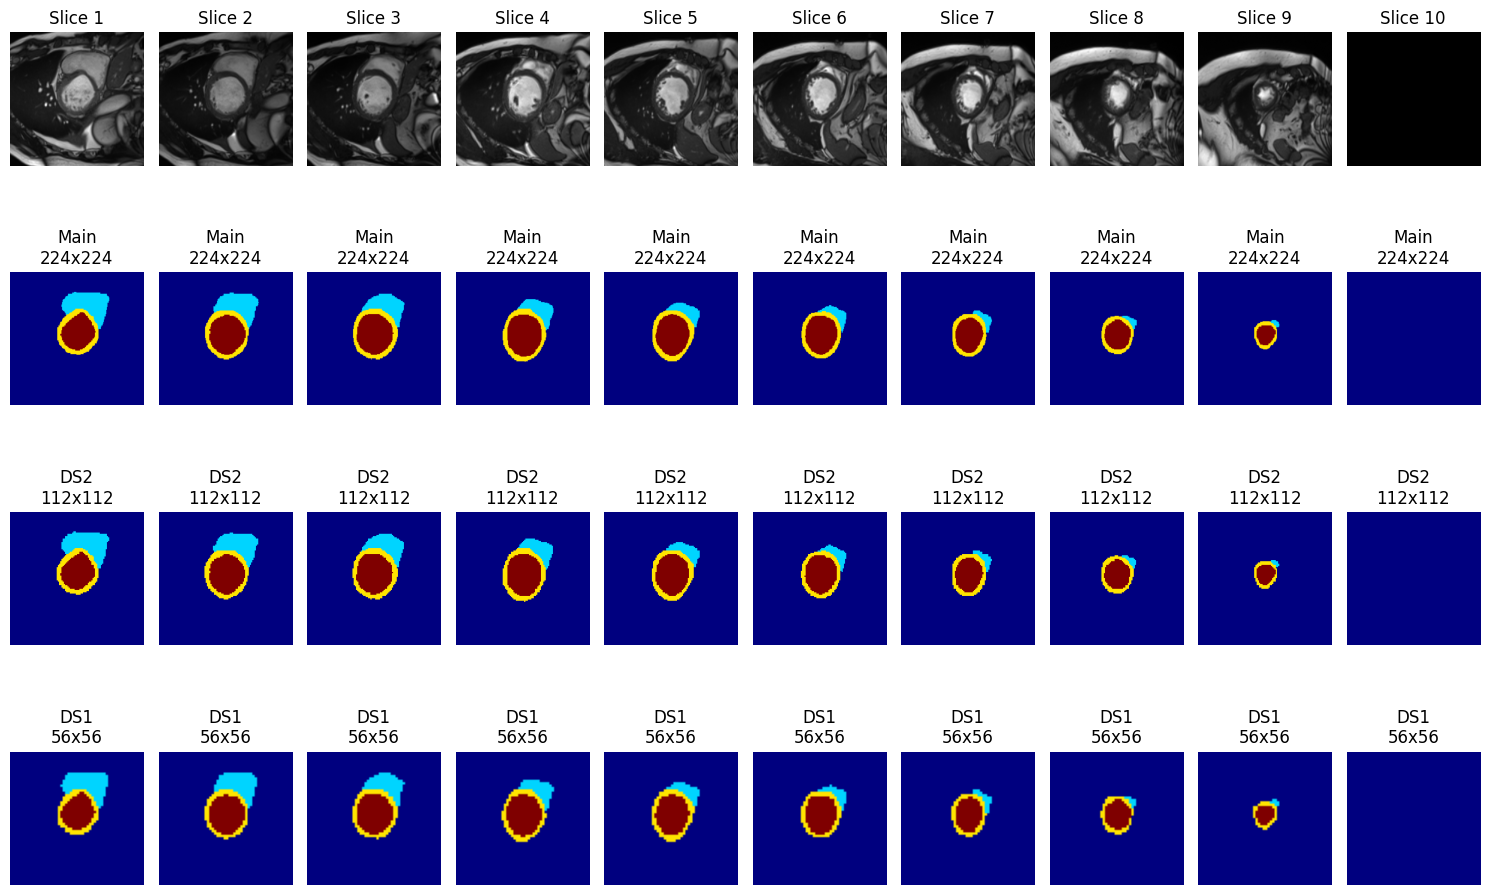

In [7]:
def visualize_multiscale_3d_sample(images, targets, index):
    image = images[index, ..., 0].numpy()  
    mask_main = tf.argmax(targets['main'][index], axis=-1).numpy()  # (224, 224, 10)
    mask_ds2 = tf.argmax(targets['ds2'][index], axis=-1).numpy()    # (112, 112, 10)
    mask_ds1 = tf.argmax(targets['ds1'][index], axis=-1).numpy()    # (56, 56, 10)

    depth = image.shape[-1]  
    fig, axs = plt.subplots(4, depth, figsize=(depth * 1.5, 10))

    for i in range(depth):
        axs[0, i].imshow(image[..., i], cmap='gray') 
        axs[0, i].set_title(f"Slice {i+1}")
        axs[0, i].axis('off')

        axs[1, i].imshow(mask_main[..., i], cmap='jet', vmin=0, vmax=3) 
        axs[1, i].set_title("Main\n224x224")
        axs[1, i].axis('off')

        axs[2, i].imshow(mask_ds2[..., i], cmap='jet', vmin=0, vmax=3)
        axs[2, i].set_title("DS2\n112x112")
        axs[2, i].axis('off')

        axs[3, i].imshow(mask_ds1[..., i], cmap='jet', vmin=0, vmax=3)
        axs[3, i].set_title("DS1\n56x56")
        axs[3, i].axis('off')

    plt.tight_layout()
    plt.show()
    
for batch in train_dataset.take(1):
    images, targets = batch
    visualize_multiscale_3d_sample(images, targets, index=0)

In [5]:
def dice_loss_per_class_3d(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []
    for i in range(1, num_classes):
        y_true_class = K.flatten(y_true[..., i])  
        y_pred_class = K.flatten(y_pred[..., i])
        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        dice_scores.append(dice)
    mean_dice = K.mean(K.stack(dice_scores), axis=0)
    return 1 - mean_dice
def dice_score_per_class_3d(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []
    for i in range(1, num_classes):  
        y_true_class = K.flatten(y_true[..., i])
        y_pred_class = K.flatten(y_pred[..., i])
        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        dice_scores.append(dice)
    return K.mean(K.stack(dice_scores), axis=0)  

In [ ]:
with strategy.scope():
    model = unet_3d() 
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  
    
    model.compile(
        optimizer=optimizer,
        loss={
            'main': dice_loss_per_class_3d,
            'ds1': dice_loss_per_class_3d,
            'ds2': dice_loss_per_class_3d
        },
        loss_weights={
            'main': 1,
            'ds1': 0.5,
            'ds2': 0.5
        },
        metrics={
            'main': [dice_score_per_class_3d]  
        }
    )
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/best_unet3D_24_filters',
    monitor='val_main_dice_score_per_class_3d',  
    mode='max',  
    save_best_only=True,
    verbose=2
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_main_dice_score_per_class_3d',
    factor=0.8, 
    patience=10,  
    min_lr=1e-6, 
    mode='max',  
    verbose=2
)
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=150,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/150
INFO:tensorflow:Collective all_reduce tensors: 86 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 86 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2025-04-02 12:48:57.226069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-04-02 12:48:57.581828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-04-02 12:48:57.884460: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-02 12:48:58.684825: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-02 12:48:58.910686: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_1_bfc) ran out of memory trying to allocate 5.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-02 12:48:

40/40 [==============================] - ETA: 0s - loss: 1.6993 - main_loss: 0.8959 - ds1_loss: 0.7410 - ds2_loss: 0.8660 - main_dice_score_per_class_3d: 0.1041
Epoch 1: val_main_dice_score_per_class_3d improved from -inf to 0.01473, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 58s 742ms/step - loss: 1.6993 - main_loss: 0.8959 - ds1_loss: 0.7410 - ds2_loss: 0.8660 - main_dice_score_per_class_3d: 0.1041 - val_loss: 1.9601 - val_main_loss: 0.9853 - val_ds1_loss: 0.9691 - val_ds2_loss: 0.9805 - val_main_dice_score_per_class_3d: 0.0147 - lr: 0.0010
Epoch 2/150
40/40 [==============================] - ETA: 0s - loss: 1.2439 - main_loss: 0.6869 - ds1_loss: 0.5231 - ds2_loss: 0.5909 - main_dice_score_per_class_3d: 0.3131
Epoch 2: val_main_dice_score_per_class_3d improved from 0.01473 to 0.04551, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 28s 688ms/step - loss: 1.2439 - main_loss: 0.6869 - ds1_loss: 0.5231 - ds2_loss: 0.5909 - main_dice_score_per_class_3d: 0.3131 - val_loss: 1.9097 - val_main_loss: 0.9545 - val_ds1_loss: 0.9644 - val_ds2_loss: 0.9460 - val_main_dice_score_per_class_3d: 0.0455 - lr: 0.0010
Epoch 3/150
40/40 [==============================] - ETA: 0s - loss: 1.0852 - main_loss: 0.5619 - ds1_loss: 0.5160 - ds2_loss: 0.5306 - main_dice_score_per_class_3d: 0.4381
Epoch 3: val_main_dice_score_per_class_3d did not improve from 0.04551
40/40 [==============================] - 20s 502ms/step - loss: 1.0852 - main_loss: 0.5619 - ds1_loss: 0.5160 - ds2_loss: 0.5306 - main_dice_score_per_class_3d: 0.4381 - val_loss: 1.9503 - val_main_loss: 0.9787 - val_ds1_loss: 0.9673 - val_ds2_loss: 0.9760 - val_main_dice_score_per_class_3d: 0.0213 - lr: 0.0010
Epoch 4/150
40/40 [==============================] - ETA: 0s - loss: 0.9935 - main_loss: 0.5051 - ds1_loss: 0.4838 - ds2_loss: 0.4

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 31s 763ms/step - loss: 0.9935 - main_loss: 0.5051 - ds1_loss: 0.4838 - ds2_loss: 0.4931 - main_dice_score_per_class_3d: 0.4949 - val_loss: 1.7147 - val_main_loss: 0.8949 - val_ds1_loss: 0.7859 - val_ds2_loss: 0.8538 - val_main_dice_score_per_class_3d: 0.1051 - lr: 0.0010
Epoch 5/150
40/40 [==============================] - ETA: 0s - loss: 0.9510 - main_loss: 0.4819 - ds1_loss: 0.4638 - ds2_loss: 0.4745 - main_dice_score_per_class_3d: 0.5181
Epoch 5: val_main_dice_score_per_class_3d improved from 0.10514 to 0.27733, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 29s 725ms/step - loss: 0.9510 - main_loss: 0.4819 - ds1_loss: 0.4638 - ds2_loss: 0.4745 - main_dice_score_per_class_3d: 0.5181 - val_loss: 1.3956 - val_main_loss: 0.7227 - val_ds1_loss: 0.6526 - val_ds2_loss: 0.6933 - val_main_dice_score_per_class_3d: 0.2773 - lr: 0.0010
Epoch 6/150
40/40 [==============================] - ETA: 0s - loss: 0.9379 - main_loss: 0.4817 - ds1_loss: 0.4362 - ds2_loss: 0.4763 - main_dice_score_per_class_3d: 0.5183
Epoch 6: val_main_dice_score_per_class_3d improved from 0.27733 to 0.45137, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 29s 719ms/step - loss: 0.9379 - main_loss: 0.4817 - ds1_loss: 0.4362 - ds2_loss: 0.4763 - main_dice_score_per_class_3d: 0.5183 - val_loss: 1.0294 - val_main_loss: 0.5486 - val_ds1_loss: 0.4340 - val_ds2_loss: 0.5275 - val_main_dice_score_per_class_3d: 0.4514 - lr: 0.0010
Epoch 7/150
40/40 [==============================] - ETA: 0s - loss: 0.8581 - main_loss: 0.4634 - ds1_loss: 0.3351 - ds2_loss: 0.4543 - main_dice_score_per_class_3d: 0.5366
Epoch 7: val_main_dice_score_per_class_3d did not improve from 0.45137
40/40 [==============================] - 24s 588ms/step - loss: 0.8581 - main_loss: 0.4634 - ds1_loss: 0.3351 - ds2_loss: 0.4543 - main_dice_score_per_class_3d: 0.5366 - val_loss: 1.0551 - val_main_loss: 0.5667 - val_ds1_loss: 0.4208 - val_ds2_loss: 0.5560 - val_main_dice_score_per_class_3d: 0.4333 - lr: 0.0010
Epoch 8/150
40/40 [==============================] - ETA: 0s - loss: 0.8259 - main_loss: 0.4560 - ds1_loss: 0.2935 - ds2_loss: 0.4

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 30s 752ms/step - loss: 0.7802 - main_loss: 0.4430 - ds1_loss: 0.2418 - ds2_loss: 0.4327 - main_dice_score_per_class_3d: 0.5570 - val_loss: 0.8063 - val_main_loss: 0.4390 - val_ds1_loss: 0.3001 - val_ds2_loss: 0.4346 - val_main_dice_score_per_class_3d: 0.5610 - lr: 0.0010
Epoch 10/150
40/40 [==============================] - ETA: 0s - loss: 0.7539 - main_loss: 0.4326 - ds1_loss: 0.2213 - ds2_loss: 0.4213 - main_dice_score_per_class_3d: 0.5674
Epoch 10: val_main_dice_score_per_class_3d improved from 0.56102 to 0.58238, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 30s 760ms/step - loss: 0.7539 - main_loss: 0.4326 - ds1_loss: 0.2213 - ds2_loss: 0.4213 - main_dice_score_per_class_3d: 0.5674 - val_loss: 0.7502 - val_main_loss: 0.4176 - val_ds1_loss: 0.2541 - val_ds2_loss: 0.4111 - val_main_dice_score_per_class_3d: 0.5824 - lr: 0.0010
Epoch 11/150
40/40 [==============================] - ETA: 0s - loss: 0.7395 - main_loss: 0.4288 - ds1_loss: 0.2102 - ds2_loss: 0.4112 - main_dice_score_per_class_3d: 0.5712
Epoch 11: val_main_dice_score_per_class_3d improved from 0.58238 to 0.59169, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 27s 683ms/step - loss: 0.7395 - main_loss: 0.4288 - ds1_loss: 0.2102 - ds2_loss: 0.4112 - main_dice_score_per_class_3d: 0.5712 - val_loss: 0.6900 - val_main_loss: 0.4083 - val_ds1_loss: 0.1868 - val_ds2_loss: 0.3766 - val_main_dice_score_per_class_3d: 0.5917 - lr: 0.0010
Epoch 12/150
40/40 [==============================] - ETA: 0s - loss: 0.6955 - main_loss: 0.4157 - ds1_loss: 0.2025 - ds2_loss: 0.3570 - main_dice_score_per_class_3d: 0.5843
Epoch 12: val_main_dice_score_per_class_3d did not improve from 0.59169
40/40 [==============================] - 22s 554ms/step - loss: 0.6955 - main_loss: 0.4157 - ds1_loss: 0.2025 - ds2_loss: 0.3570 - main_dice_score_per_class_3d: 0.5843 - val_loss: 0.9198 - val_main_loss: 0.5135 - val_ds1_loss: 0.3516 - val_ds2_loss: 0.4612 - val_main_dice_score_per_class_3d: 0.4865 - lr: 0.0010
Epoch 13/150
40/40 [==============================] - ETA: 0s - loss: 0.6188 - main_loss: 0.4148 - ds1_loss: 0.1938 - ds2_loss: 

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 30s 757ms/step - loss: 0.5266 - main_loss: 0.3478 - ds1_loss: 0.1764 - ds2_loss: 0.1812 - main_dice_score_per_class_3d: 0.6522 - val_loss: 0.4758 - val_main_loss: 0.2879 - val_ds1_loss: 0.1741 - val_ds2_loss: 0.2018 - val_main_dice_score_per_class_3d: 0.7121 - lr: 0.0010
Epoch 16/150
40/40 [==============================] - ETA: 0s - loss: 0.3523 - main_loss: 0.1833 - ds1_loss: 0.1686 - ds2_loss: 0.1694 - main_dice_score_per_class_3d: 0.8167
Epoch 16: val_main_dice_score_per_class_3d did not improve from 0.71211
40/40 [==============================] - 21s 515ms/step - loss: 0.3523 - main_loss: 0.1833 - ds1_loss: 0.1686 - ds2_loss: 0.1694 - main_dice_score_per_class_3d: 0.8167 - val_loss: 0.7225 - val_main_loss: 0.4082 - val_ds1_loss: 0.3020 - val_ds2_loss: 0.3265 - val_main_dice_score_per_class_3d: 0.5918 - lr: 0.0010
Epoch 17/150
40/40 [==============================] - ETA: 0s - loss: 0.3622 - main_loss: 0.1832 - ds1_loss: 0.1786 - ds2_loss: 

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 29s 732ms/step - loss: 0.3212 - main_loss: 0.1613 - ds1_loss: 0.1595 - ds2_loss: 0.1601 - main_dice_score_per_class_3d: 0.8387 - val_loss: 0.4430 - val_main_loss: 0.2396 - val_ds1_loss: 0.1896 - val_ds2_loss: 0.2171 - val_main_dice_score_per_class_3d: 0.7604 - lr: 0.0010
Epoch 19/150
40/40 [==============================] - ETA: 0s - loss: 0.3034 - main_loss: 0.1520 - ds1_loss: 0.1520 - ds2_loss: 0.1507 - main_dice_score_per_class_3d: 0.8480
Epoch 19: val_main_dice_score_per_class_3d did not improve from 0.76036
40/40 [==============================] - 21s 529ms/step - loss: 0.3034 - main_loss: 0.1520 - ds1_loss: 0.1520 - ds2_loss: 0.1507 - main_dice_score_per_class_3d: 0.8480 - val_loss: 0.5525 - val_main_loss: 0.2923 - val_ds1_loss: 0.2499 - val_ds2_loss: 0.2705 - val_main_dice_score_per_class_3d: 0.7077 - lr: 0.0010
Epoch 20/150
40/40 [==============================] - ETA: 0s - loss: 0.3027 - main_loss: 0.1517 - ds1_loss: 0.1511 - ds2_loss: 

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 28s 708ms/step - loss: 0.3027 - main_loss: 0.1517 - ds1_loss: 0.1511 - ds2_loss: 0.1510 - main_dice_score_per_class_3d: 0.8483 - val_loss: 0.3626 - val_main_loss: 0.1896 - val_ds1_loss: 0.1675 - val_ds2_loss: 0.1784 - val_main_dice_score_per_class_3d: 0.8104 - lr: 0.0010
Epoch 21/150
40/40 [==============================] - ETA: 0s - loss: 0.2762 - main_loss: 0.1384 - ds1_loss: 0.1382 - ds2_loss: 0.1374 - main_dice_score_per_class_3d: 0.8616
Epoch 21: val_main_dice_score_per_class_3d improved from 0.81037 to 0.83781, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 28s 707ms/step - loss: 0.2762 - main_loss: 0.1384 - ds1_loss: 0.1382 - ds2_loss: 0.1374 - main_dice_score_per_class_3d: 0.8616 - val_loss: 0.3182 - val_main_loss: 0.1622 - val_ds1_loss: 0.1529 - val_ds2_loss: 0.1591 - val_main_dice_score_per_class_3d: 0.8378 - lr: 0.0010
Epoch 22/150
40/40 [==============================] - ETA: 0s - loss: 0.2866 - main_loss: 0.1430 - ds1_loss: 0.1441 - ds2_loss: 0.1433 - main_dice_score_per_class_3d: 0.8570
Epoch 22: val_main_dice_score_per_class_3d improved from 0.83781 to 0.85622, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 29s 719ms/step - loss: 0.2866 - main_loss: 0.1430 - ds1_loss: 0.1441 - ds2_loss: 0.1433 - main_dice_score_per_class_3d: 0.8570 - val_loss: 0.2849 - val_main_loss: 0.1438 - val_ds1_loss: 0.1408 - val_ds2_loss: 0.1416 - val_main_dice_score_per_class_3d: 0.8562 - lr: 0.0010
Epoch 23/150
40/40 [==============================] - ETA: 0s - loss: 0.2751 - main_loss: 0.1377 - ds1_loss: 0.1379 - ds2_loss: 0.1370 - main_dice_score_per_class_3d: 0.8623
Epoch 23: val_main_dice_score_per_class_3d did not improve from 0.85622
40/40 [==============================] - 22s 548ms/step - loss: 0.2751 - main_loss: 0.1377 - ds1_loss: 0.1379 - ds2_loss: 0.1370 - main_dice_score_per_class_3d: 0.8623 - val_loss: 0.3331 - val_main_loss: 0.1703 - val_ds1_loss: 0.1581 - val_ds2_loss: 0.1676 - val_main_dice_score_per_class_3d: 0.8297 - lr: 0.0010
Epoch 24/150
40/40 [==============================] - ETA: 0s - loss: 0.2742 - main_loss: 0.1373 - ds1_loss: 0.1374 - ds2_loss: 

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 30s 747ms/step - loss: 0.2499 - main_loss: 0.1249 - ds1_loss: 0.1254 - ds2_loss: 0.1246 - main_dice_score_per_class_3d: 0.8751 - val_loss: 0.2655 - val_main_loss: 0.1358 - val_ds1_loss: 0.1274 - val_ds2_loss: 0.1321 - val_main_dice_score_per_class_3d: 0.8642 - lr: 0.0010
Epoch 30/150
40/40 [==============================] - ETA: 0s - loss: 0.2477 - main_loss: 0.1237 - ds1_loss: 0.1245 - ds2_loss: 0.1236 - main_dice_score_per_class_3d: 0.8763
Epoch 30: val_main_dice_score_per_class_3d improved from 0.86422 to 0.86805, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 27s 685ms/step - loss: 0.2477 - main_loss: 0.1237 - ds1_loss: 0.1245 - ds2_loss: 0.1236 - main_dice_score_per_class_3d: 0.8763 - val_loss: 0.2588 - val_main_loss: 0.1319 - val_ds1_loss: 0.1251 - val_ds2_loss: 0.1286 - val_main_dice_score_per_class_3d: 0.8681 - lr: 0.0010
Epoch 31/150
40/40 [==============================] - ETA: 0s - loss: 0.2464 - main_loss: 0.1232 - ds1_loss: 0.1232 - ds2_loss: 0.1232 - main_dice_score_per_class_3d: 0.8768
Epoch 31: val_main_dice_score_per_class_3d did not improve from 0.86805
40/40 [==============================] - 22s 546ms/step - loss: 0.2464 - main_loss: 0.1232 - ds1_loss: 0.1232 - ds2_loss: 0.1232 - main_dice_score_per_class_3d: 0.8768 - val_loss: 0.4300 - val_main_loss: 0.2187 - val_ds1_loss: 0.2040 - val_ds2_loss: 0.2186 - val_main_dice_score_per_class_3d: 0.7813 - lr: 0.0010
Epoch 32/150
40/40 [==============================] - ETA: 0s - loss: 0.2557 - main_loss: 0.1276 - ds1_loss: 0.1288 - ds2_loss: 

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 30s 753ms/step - loss: 0.2513 - main_loss: 0.1251 - ds1_loss: 0.1269 - ds2_loss: 0.1255 - main_dice_score_per_class_3d: 0.8749 - val_loss: 0.2416 - val_main_loss: 0.1205 - val_ds1_loss: 0.1214 - val_ds2_loss: 0.1208 - val_main_dice_score_per_class_3d: 0.8795 - lr: 0.0010
Epoch 35/150
40/40 [==============================] - ETA: 0s - loss: 0.2421 - main_loss: 0.1209 - ds1_loss: 0.1216 - ds2_loss: 0.1209 - main_dice_score_per_class_3d: 0.8791
Epoch 35: val_main_dice_score_per_class_3d improved from 0.87950 to 0.88071, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 27s 671ms/step - loss: 0.2421 - main_loss: 0.1209 - ds1_loss: 0.1216 - ds2_loss: 0.1209 - main_dice_score_per_class_3d: 0.8791 - val_loss: 0.2382 - val_main_loss: 0.1193 - val_ds1_loss: 0.1184 - val_ds2_loss: 0.1195 - val_main_dice_score_per_class_3d: 0.8807 - lr: 0.0010
Epoch 36/150
40/40 [==============================] - ETA: 0s - loss: 0.2393 - main_loss: 0.1196 - ds1_loss: 0.1194 - ds2_loss: 0.1199 - main_dice_score_per_class_3d: 0.8804
Epoch 36: val_main_dice_score_per_class_3d did not improve from 0.88071
40/40 [==============================] - 23s 571ms/step - loss: 0.2393 - main_loss: 0.1196 - ds1_loss: 0.1194 - ds2_loss: 0.1199 - main_dice_score_per_class_3d: 0.8804 - val_loss: 0.2487 - val_main_loss: 0.1235 - val_ds1_loss: 0.1259 - val_ds2_loss: 0.1245 - val_main_dice_score_per_class_3d: 0.8765 - lr: 0.0010
Epoch 37/150
40/40 [==============================] - ETA: 0s - loss: 0.2348 - main_loss: 0.1171 - ds1_loss: 0.1184 - ds2_loss: 

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 30s 761ms/step - loss: 0.2233 - main_loss: 0.1114 - ds1_loss: 0.1127 - ds2_loss: 0.1111 - main_dice_score_per_class_3d: 0.8886 - val_loss: 0.2311 - val_main_loss: 0.1171 - val_ds1_loss: 0.1133 - val_ds2_loss: 0.1146 - val_main_dice_score_per_class_3d: 0.8829 - lr: 0.0010
Epoch 40/150
40/40 [==============================] - ETA: 0s - loss: 0.2229 - main_loss: 0.1115 - ds1_loss: 0.1119 - ds2_loss: 0.1110 - main_dice_score_per_class_3d: 0.8885
Epoch 40: val_main_dice_score_per_class_3d did not improve from 0.88291
40/40 [==============================] - 21s 509ms/step - loss: 0.2229 - main_loss: 0.1115 - ds1_loss: 0.1119 - ds2_loss: 0.1110 - main_dice_score_per_class_3d: 0.8885 - val_loss: 0.2674 - val_main_loss: 0.1347 - val_ds1_loss: 0.1295 - val_ds2_loss: 0.1360 - val_main_dice_score_per_class_3d: 0.8653 - lr: 0.0010
Epoch 41/150
40/40 [==============================] - ETA: 0s - loss: 0.2117 - main_loss: 0.1058 - ds1_loss: 0.1060 - ds2_loss: 

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 30s 758ms/step - loss: 0.2092 - main_loss: 0.1047 - ds1_loss: 0.1046 - ds2_loss: 0.1042 - main_dice_score_per_class_3d: 0.8953 - val_loss: 0.2168 - val_main_loss: 0.1082 - val_ds1_loss: 0.1086 - val_ds2_loss: 0.1086 - val_main_dice_score_per_class_3d: 0.8918 - lr: 0.0010
Epoch 47/150
40/40 [==============================] - ETA: 0s - loss: 0.2107 - main_loss: 0.1054 - ds1_loss: 0.1051 - ds2_loss: 0.1054 - main_dice_score_per_class_3d: 0.8946
Epoch 47: val_main_dice_score_per_class_3d did not improve from 0.89182
40/40 [==============================] - 23s 571ms/step - loss: 0.2107 - main_loss: 0.1054 - ds1_loss: 0.1051 - ds2_loss: 0.1054 - main_dice_score_per_class_3d: 0.8946 - val_loss: 0.3023 - val_main_loss: 0.1519 - val_ds1_loss: 0.1489 - val_ds2_loss: 0.1518 - val_main_dice_score_per_class_3d: 0.8481 - lr: 0.0010
Epoch 48/150
40/40 [==============================] - ETA: 0s - loss: 0.2123 - main_loss: 0.1061 - ds1_loss: 0.1063 - ds2_loss: 

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 30s 746ms/step - loss: 0.1770 - main_loss: 0.0886 - ds1_loss: 0.0881 - ds2_loss: 0.0887 - main_dice_score_per_class_3d: 0.9114 - val_loss: 0.2013 - val_main_loss: 0.1010 - val_ds1_loss: 0.1004 - val_ds2_loss: 0.1004 - val_main_dice_score_per_class_3d: 0.8990 - lr: 6.4000e-04
Epoch 68/150
40/40 [==============================] - ETA: 0s - loss: 0.1747 - main_loss: 0.0876 - ds1_loss: 0.0869 - ds2_loss: 0.0874 - main_dice_score_per_class_3d: 0.9124
Epoch 68: val_main_dice_score_per_class_3d improved from 0.89905 to 0.89980, saving model to models/best_unet3D_24_filters
INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 28s 716ms/step - loss: 0.1747 - main_loss: 0.0876 - ds1_loss: 0.0869 - ds2_loss: 0.0874 - main_dice_score_per_class_3d: 0.9124 - val_loss: 0.2005 - val_main_loss: 0.1002 - val_ds1_loss: 0.1004 - val_ds2_loss: 0.1003 - val_main_dice_score_per_class_3d: 0.8998 - lr: 6.4000e-04
Epoch 69/150
40/40 [==============================] - ETA: 0s - loss: 0.1712 - main_loss: 0.0858 - ds1_loss: 0.0854 - ds2_loss: 0.0855 - main_dice_score_per_class_3d: 0.9142
Epoch 69: val_main_dice_score_per_class_3d did not improve from 0.89980
40/40 [==============================] - 22s 554ms/step - loss: 0.1712 - main_loss: 0.0858 - ds1_loss: 0.0854 - ds2_loss: 0.0855 - main_dice_score_per_class_3d: 0.9142 - val_loss: 0.2161 - val_main_loss: 0.1088 - val_ds1_loss: 0.1067 - val_ds2_loss: 0.1078 - val_main_dice_score_per_class_3d: 0.8912 - lr: 6.4000e-04
Epoch 70/150
40/40 [==============================] - ETA: 0s - loss: 0.1727 - main_loss: 0.0867 - ds1_loss: 0.0856 - ds

INFO:tensorflow:Assets written to: models/best_unet3D_24_filters/assets


40/40 [==============================] - 29s 727ms/step - loss: 0.1353 - main_loss: 0.0684 - ds1_loss: 0.0661 - ds2_loss: 0.0676 - main_dice_score_per_class_3d: 0.9316 - val_loss: 0.1985 - val_main_loss: 0.0988 - val_ds1_loss: 0.0997 - val_ds2_loss: 0.0998 - val_main_dice_score_per_class_3d: 0.9012 - lr: 1.6777e-04
Epoch 134/150
40/40 [==============================] - ETA: 0s - loss: 0.1365 - main_loss: 0.0690 - ds1_loss: 0.0663 - ds2_loss: 0.0687 - main_dice_score_per_class_3d: 0.9310
Epoch 134: val_main_dice_score_per_class_3d did not improve from 0.90123
40/40 [==============================] - 21s 529ms/step - loss: 0.1365 - main_loss: 0.0690 - ds1_loss: 0.0663 - ds2_loss: 0.0687 - main_dice_score_per_class_3d: 0.9310 - val_loss: 0.2078 - val_main_loss: 0.1036 - val_ds1_loss: 0.1036 - val_ds2_loss: 0.1047 - val_main_dice_score_per_class_3d: 0.8964 - lr: 1.6777e-04
Epoch 135/150
40/40 [==============================] - ETA: 0s - loss: 0.1331 - main_loss: 0.0672 - ds1_loss: 0.0646 -

: 